## Machine Learning


## Importando as bibliotecas para o projeto

In [64]:
# # Importar bibliotecas

# execute a linha abaixo apenas se não tiver o Sweetviz
# ! pip install sweetviz

%matplotlib inline
from pprint import pprint
from time import time
import logging
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import sweetviz as sv
from joblib import dump, load
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

print(__doc__)
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,format='%(asctime)s %(levelname)s %(message)s')

Automatically created module for IPython interactive environment


## Importação e tratamento do Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1770 entries, 0 to 1769
Data columns (total 8 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   Título do Ajuste - conforme relatório SUMÁRIO-001  1770 non-null   object
 1   Descrição do Ajuste                                1770 non-null   object
 2   Descrição de Impacto                               1770 non-null   object
 3   Impacto Principal                                  1770 non-null   object
 4   Observação                                         624 non-null    object
 5   TIPO                                               1770 non-null   object
 6   NOME                                               1693 non-null   object
 7   todas_as_colunas                                   1770 non-null   object
dtypes: object(8)
memory usage: 110.8+ KB


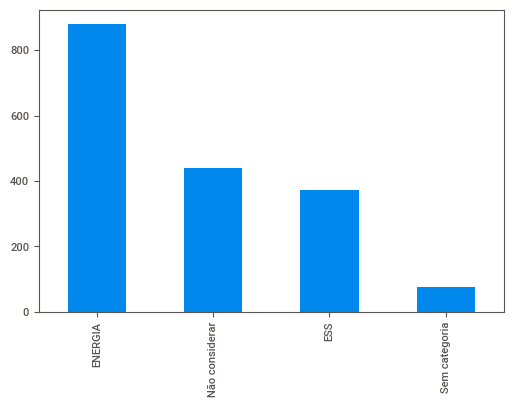

In [29]:
# Importando arquivo "saidamerged.xlsx"
merged = pd.read_excel('saidamerged.xlsx', usecols=['Título do Ajuste - conforme relatório SUMÁRIO-001',
       'Descrição do Ajuste', 'Descrição de Impacto', 'Impacto Principal',
       'Observação', 'NOME', 'TIPO'])

# Plotando os principais tipos de categoria para análise de balanceamento
merged['TIPO'].value_counts().plot(kind='bar')

# Substituindo o NaN pelo " " a fim de poder usar a a biblioteca TfidfVectorizer
merged['TIPO'].fillna('Sem categoria', inplace=True)
merged['Título do Ajuste - conforme relatório SUMÁRIO-001'].fillna('', inplace=True)
merged['Descrição do Ajuste'].fillna('', inplace=True)
merged['Descrição de Impacto'].fillna('', inplace=True)
merged['Impacto Principal'].fillna('', inplace=True)

# cria novas colunas concatenando todas colunas de texto do Dataframe
# Esta é a coluna da variável X (INDEPENDENTE)
merged['todas_as_colunas']=merged['Título do Ajuste - conforme relatório SUMÁRIO-001']+merged['Descrição do Ajuste']+merged['Descrição de Impacto']+merged['Impacto Principal']

# Mostrando o Dataset final
merged.info()

### Análise Exploratória utilizando biblioteca SWEETVIZ

In [30]:
#analyzing the dataset
advert_report = sv.analyze(merged)
#display the report
advert_report.show_html('Advertising.html')


Report Advertising.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [25]:
# Verificando se a coluna da variável independente ainda tem NaN:
merged['todas_as_colunas'].isna().sum()

0

In [27]:
# Análise inicial do vocabulário encontrado no texto da coluna "merged['todas_as_colunas']"

text = merged['todas_as_colunas']

# instancia o transform TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# tokeniza e cria o vocabulário
tfidf_vectorizer.fit(text)

# mostra o vocabulário criado
print('Vocabulário: ')
print(tfidf_vectorizer.vocabulary_)
print('\nPeso de cada palavra do vocabulário: ')
print(tfidf_vectorizer.idf_)

# encode document
tfidf_vector = tfidf_vectorizer.transform(text)

# mostra as dimensões da matrix de frequência
print('\nDimensões da matrix: ')
print(tfidf_vector.shape)

# mostra os documentos codificados
val = tfidf_vectorizer.fit_transform(text)
feature_names = tfidf_vectorizer.get_feature_names()
print('\n',text[0],'\n',text[1],'\n',text[2],'\n',text[3],'\n',text[4],'\n')
pd.DataFrame(val.toarray(), columns = feature_names)
# print(tfidf_vector.toarray())

Vocabulário: 
{'encargo': 1410, 'liquidação': 1903, 'mcp': 2004, 'original': 2184, 'principal': 2353, 'inadimplência': 1700, 'do': 1341, 'mercado': 2018, 'de': 1200, 'curto': 1181, 'prazo': 2339, 'janeiro': 1787, '2020são': 385, 'impactados': 1685, 'os': 2187, 'agentes': 701, 'inadimplentes': 1699, 'da': 1189, '2020': 381, 'em': 1399, 'posição': 2331, 'devedora': 1256, 'ou': 2188, 'credora': 1165, 'estorno': 1465, 'celesc': 1007, 'dist': 1329, 'vibeoli': 2794, 'ceramica': 1017, 'dos': 1345, 'devido': 1263, 'aos': 827, 'parcelamentos': 2249, 'deliberação': 1220, '1217': 198, 'cad': 955, '1025ª': 173, '0055': 76, '1098ª': 183, 'respectivamente': 2480, 'impactando': 1687, 'débito': 1352, 'credores': 1166, 'contabilização': 1122, 'juros': 1874, 'lançamento': 1880, 'sobre': 2639, 'dezembro': 1310, '2019': 375, 'período': 2303, '10': 150, '03': 99, 'até': 890, '06': 126, '04': 115, '2020este': 383, 'ajuste': 779, 'impacta': 1682, 'crédito': 1176, 'que': 2388, 'possuem': 2332, 'valores': 2776


Dimensões da matrix: 
(1770, 2827)

 Encargo Liquidação MCP - Original - Principal (*)Inadimplência do MCP (Mercado de Curto Prazo) de Janeiro/2020São impactados os Agentes inadimplentes da liquidação do MCP de Janeiro/2020 em posição devedora ou credora.- 
 Encargo Liquidação MCP - Estorno -  Principal (*)Estorno da Inadimplência do MCP (Mercado de Curto Prazo) de Janeiro/2020- (CELESC DIST e VIBEOLI CERAMICA)Estorno da inadimplência dos agentes CELESC DIST e VIBEOLI CERAMICA devido aos parcelamentos (Deliberação 1217 CAd 1025ª e Deliberação 0055 CAd 1098ª, respectivamente) impactando a débito os agentes credores da contabilização de Janeiro/2020.- 
 Encargo Liquidação MCP - Original - Juros (*)Lançamento dos Juros sobre a Inadimplência do MCP (Mercado de Curto Prazo) de Dezembro/2019 do período de 10/03/2020 até 06/04/2020São impactados os Agentes inadimplentes da liquidação do MCP de Janeiro/2020, em posição devedora ou credora.- 
 Encargo Liquidação MCP - Estorno - Juros (*)Estorn

,00,000,0000,0000_70,0000_abr19esse,0000_abr20esse,0000_ago19esse,0000_ago20esse,0000_dez20esse,0000_jul19esse,...,zul,às,âmbito,época,índice,últimas,últimos,única,único,únicoprocesso
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078879,0.0


## Técnica HOLD-OUT na proporção 80% e 20% na escolha dos dados de Treino e Teste

In [33]:
# Separa os dados de treino e teste (proporção 80/20)
# Stratify = pega representante de todas as classes, corrije desbaleamento
from sklearn.model_selection import train_test_split

# Variável Independente:
X = merged['todas_as_colunas']
# Variável Dependente (Target)
y = merged['TIPO']

# Divisão Treino e Teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y,random_state=42)


In [34]:
X_train[:5]

1386    Ação 1008485- 93.2017.4.01.3400 - Dez19Esse aj...
1305    Resolução 545-13 - ITAJAI BIOGAS - Abr20Resolu...
465     REN 736/16 - Diferença de Juros - Jun/16\nREN ...
253     Ajuste Único CNPE 03/13 - Ref. Nov/2014Ver rel...
1184    Liminar nº 0043973-15.2015.4.01.000_Ago17Ratei...
Name: todas_as_colunas, dtype: object

In [36]:
# Confere a proporção das classes nos dados de treino e de teste

print('TREINO : ',y_train.shape,'\n', y_train.value_counts(normalize=True),'\n')
print('TESTE  : ',y_test.shape,'\n', y_test.value_counts(normalize=True))

# Observamos que existe a mesma proporção das variáveis na amostra de treino e de teste,  que ajudará a dar maior pecisão ao modelo.

TREINO :  (1416,) 
 ENERGIA           0.496469
Não considerar    0.249294
ESS               0.210452
Sem categoria     0.043785
Name: TIPO, dtype: float64 

TESTE  :  (354,) 
 ENERGIA           0.497175
Não considerar    0.248588
ESS               0.211864
Sem categoria     0.042373
Name: TIPO, dtype: float64


In [ ]:
# Com o dataframe já dividido entre Treino e Teste, iremos obter o vocabulário apenas dos dados de TREINO:

# instancia o transform CountVectorizer
tfidf_vectorizer = TfidfVectorizer()
# # tokeniza e cria o vocabulário
tfidf_vectorizer.fit(X_train)
# # mostra o vocabulário criado
print('Vocabulário: ')
print(tfidf_vectorizer.vocabulary_)

# encode document
tfidf_vector = tfidf_vectorizer.transform(X_train)
# mostra as dimensões da matrix de frequência
print('\nDimensões da matrix: ')
print(tfidf_vector.shape)

## Treinando o Classificador:

In [41]:
# Define o pipeline incluindo o extrator de 'features do texto e um classificador
# No caso abaixo utilizamos:
# Bag of words (sklearn CountVectorizer) e TI IDF para identificação de dicionários de texto
# Regressão logística dentro do SGD Classifier como algoritmo para obter a acurária do projeto:

pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=1.0, max_features=50000,ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True,norm='l2')),
    ('clf', SGDClassifier(loss='log',alpha=1e-06, penalty='elasticnet', max_iter=60)), 
])

# O padrão é hinge, mas utiizamos default hinge. to get proba=log or modified_huber

In [58]:
# Treinando o modelo e obtendo o tempo do processamento:
%time
classificador = pipeline.fit(X_train, y_train)

# Acurácia do modelo nos dados de treino
train_score = classificador.score(X_train, y_train)

# Acurácia do modelo nos dados de teste 
test_score = classificador.score(X_test, y_test)

print("Train score: {}".format(train_score))
print("Test score: {}".format(test_score))

Wall time: 0 ns
Train score: 1.0
Test score: 0.9689265536723164


In [59]:
# Predição nos dados de teste (utilizaremos para o cálculo do erro)
predicted = classificador.predict(X_test)

In [69]:
# validando o modelo usando a quantidade de folds do usuário  no cross-validation:

folds = int(input("Select your item: "))
kfold = KFold(n_splits=folds, shuffle=True, random_state=42)
results = cross_validate(classificador, X_train, y_train, cv=kfold)
print("Average accuracy: %f (%f)" %(results['test_score'].mean(), results['test_score'].std()))


Select your item: 10
Average accuracy: 0.956897 (0.018028)


## Utilizando o CROSS VALIDATION com N-Folds a critério do usuário

In [77]:
# Abaixo fazemos fazemos a separação do nosso dataset três vezes (n_folds=3),
# para cada iteração realizamos o treino do modelo (model.fit(data_train, target_train)), 
# e a predição dos exemplos separados como teste (model.predict(data_test)), 
# por fim calculamos a acurácia e adicionamos em um array. 

# Ao final das iterações a média das acurácias (np.average(results_accuracy)), 
# representa uma métrica mais confiável e menos passiva de variância.

# Neste exemplo utilizamos a técnica de amostragem estratificada, presente no sklearn, 
# com intuito de preservar o balanceamento das classes.

# Fonte: https://joorgelm.medium.com/valida%C3%A7%C3%A3o-cruzada-cross-validation-avaliando-seu-modelo-de-forma-clara-e-concisa-10d27fa4efb8

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
def k_fold_cross_validation(model, x, y, n_folds=3):
    
    kf = StratifiedKFold(n_splits=n_folds)
    
    results_accuracy = []
    
    for train, test in kf.split(x, y):
        data_train, target_train = x[train], y[train]
        data_test, target_test   = x[test], y[test]
        
        model = model.fit(data_train, target_train)
        out = model.predict(data_test)
        
        accuracy = accuracy_score(target_test, out)
        results_accuracy.append(accuracy)
        
    print('accuracy')
    print(results_accuracy)
    print(np.average(results_accuracy))

k_fold_cross_validation(classificador, X, y, n_folds=5)

accuracy
[0.9548022598870056, 0.9265536723163842, 0.9519774011299436, 0.9463276836158192, 0.9689265536723164]
0.9497175141242937


In [60]:
# Mostra o f1 score do modelo nos dados de teste (usado quando as classes estão desbalanceadas)
# No caso em análise as classes estão balanceadas, ainda é necessário fazer essa análise ??

from sklearn.metrics import f1_score
f1_score(y_test, predicted, average='weighted') 

0.9672888282188263

In [50]:
# avalie o modelo usando 'classification_report' do sklearn
from sklearn import metrics
print(metrics.classification_report(y_test, predicted))

                precision    recall  f1-score   support

       ENERGIA       0.98      0.98      0.98       176
           ESS       0.97      1.00      0.99        75
Não considerar       0.97      0.99      0.98        88
 Sem categoria       0.75      0.60      0.67        15

      accuracy                           0.97       354
     macro avg       0.92      0.89      0.90       354
  weighted avg       0.97      0.97      0.97       354



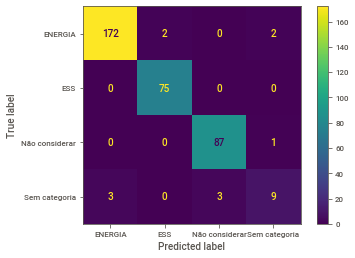

In [51]:
# mostrar a matrix de confusão do modelo sobre todo o dataset
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classificador, X_test, y_test, values_format='d')

In [52]:
# Mostra os hiperparâmetros usados para treinar o modelo
classificador.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('vect',
                 CountVectorizer(max_features=50000, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=1e-06, loss='log', max_iter=60,
                               penalty='elasticnet'))])>